In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
import pickle


In [2]:
file_path = "House Price Prediction Dataset_11.csv"
df = pd.read_csv(file_path)
df = df.dropna()


In [3]:
location_dummies = pd.get_dummies(df["Location"], drop_first=True)

In [4]:
X = pd.concat([df[["Area", "Bedrooms"]], location_dummies], axis=1).values
y = df["Price"].values

# Standardize features and target
scaler_X = StandardScaler()
X = scaler_X.fit_transform(X)

scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()


In [5]:
alpha = 0.005       # Smaller learning rate for stable convergence
epochs = 8000
k = 5

kf = KFold(n_splits=k, shuffle=True, random_state=42)
fold = 1
mse_scores = []
r2_scores = []
cost_history_all = []


In [6]:
for train_index, test_index in kf.split(X):
    print(f"\n🔹 Fold {fold}/{k}")

    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y_scaled[train_index], y_scaled[test_index]

    n, d = X_train.shape
    m = np.zeros(d)
    c = 0
    cost_history = []

    for i in range(epochs):
        y_pred = np.dot(X_train, m) + c
        error = y_pred - y_train

        cost = (1 / (2 * n)) * np.sum(error ** 2)
        cost_history.append(cost)

        dm = (1 / n) * np.dot(X_train.T, error)
        dc = (1 / n) * np.sum(error)

        m -= alpha * dm
        c -= alpha * dc

    cost_history_all.append(cost_history)

    # Evaluate on test data
    y_pred_test_scaled = np.dot(X_test, m) + c
    y_pred_test = scaler_y.inverse_transform(y_pred_test_scaled.reshape(-1, 1)).flatten()
    y_test_real = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()

    mse = np.mean((y_pred_test - y_test_real) ** 2)
    ss_total = np.sum((y_test_real - np.mean(y_test_real)) ** 2)
    ss_residual = np.sum((y_test_real - y_pred_test) ** 2)
    r2 = 1 - (ss_residual / ss_total)

    mse_scores.append(mse)
    r2_scores.append(r2)

    print(f"Fold {fold}: MSE = {mse:.2f}, R² = {r2*100:.2f}%")
    fold += 1



🔹 Fold 1/5
Fold 1: MSE = 77369035486.76, R² = 0.55%

🔹 Fold 2/5
Fold 2: MSE = 77506584251.84, R² = -0.30%

🔹 Fold 3/5
Fold 3: MSE = 77005767351.44, R² = -2.31%

🔹 Fold 4/5
Fold 4: MSE = 78432595971.33, R² = -1.01%

🔹 Fold 5/5
Fold 5: MSE = 73464468721.23, R² = -0.85%


In [7]:
print("\n✅ Average MSE across 5 folds:", np.mean(mse_scores))
print("✅ Average R² Score across 5 folds: {:.2f}%".format(np.mean(r2_scores) * 100))

features = df[["Area", "Bedrooms"]].columns.tolist() + list(location_dummies.columns)
print("\nTrained Parameters (from last fold):")
for feature, coef in zip(features, m):
    print(f"{feature:15}: {coef:.4f}")
print(f"Intercept (c): {c:.4f}")



✅ Average MSE across 5 folds: 76755690356.52118
✅ Average R² Score across 5 folds: -0.78%

Trained Parameters (from last fold):
Area           : 0.0136
Bedrooms       : 0.0040
Rural          : 0.0145
Suburban       : 0.0377
Urban          : -0.0370
Intercept (c): 0.0048


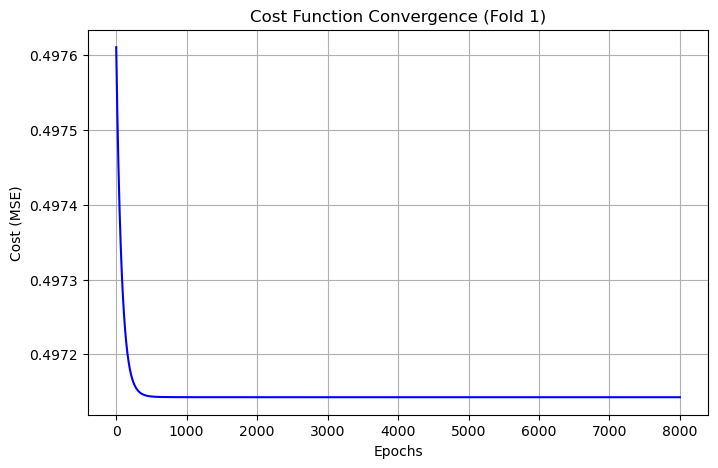

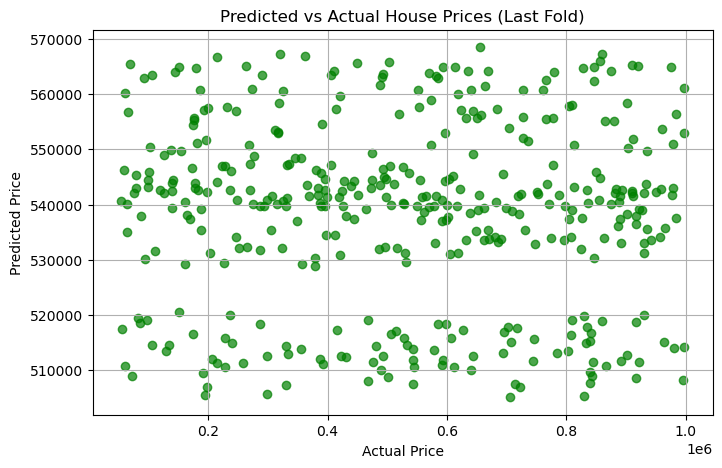

Text(0.5, 1.0, 'Feature Importance (Coefficient Magnitude)')

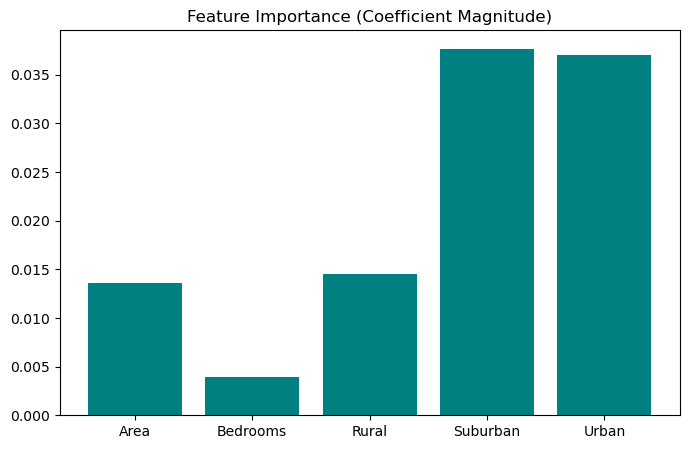

In [8]:
plt.figure(figsize=(8, 5))
plt.plot(cost_history_all[0], color='blue')
plt.title("Cost Function Convergence (Fold 1)")
plt.xlabel("Epochs")
plt.ylabel("Cost (MSE)")
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 5))
plt.scatter(y_test_real, y_pred_test, alpha=0.7, color='green')
plt.title("Predicted vs Actual House Prices (Last Fold)")
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 5))
coefficients = np.abs(m)
plt.bar(features, coefficients, color='teal')
plt.title("Feature Importance (Coefficient Magnitude)")


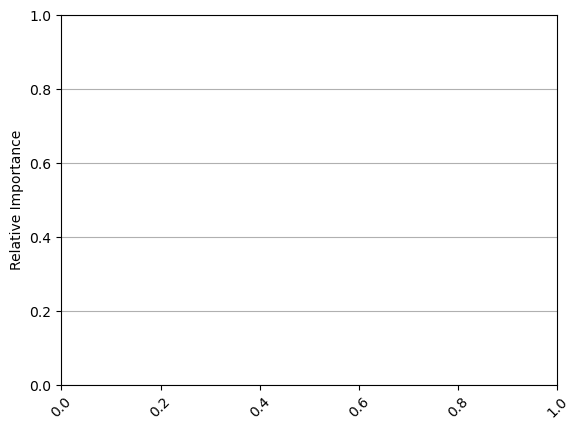

In [9]:
plt.ylabel("Relative Importance")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()


In [10]:
model_data = {
    "weights": m,
    "intercept": c,
    "scaler_X": scaler_X,
    "scaler_y": scaler_y,
    "features": features
}

with open("house_price_model.pkl", "wb") as f:
    pickle.dump(model_data, f)

print("\n💾 Model saved successfully as 'house_price_model.pkl'")



💾 Model saved successfully as 'house_price_model.pkl'


In [12]:
print("\n🔮 Example Prediction:")

# Example input
new_data = pd.DataFrame({
    "Area": [3500],
    "Bedrooms": [4],
    "Location": ["Urban"]
})

# One-hot encode with same structure
new_location = pd.get_dummies(new_data["Location"])
for col in location_dummies.columns:
    if col not in new_location.columns:
        new_location[col] = 0
new_location = new_location[location_dummies.columns]

# Combine features
new_X = pd.concat([new_data[["Area", "Bedrooms"]], new_location], axis=1)
new_X = scaler_X.transform(new_X)

# Predict
predicted_scaled = np.dot(new_X, m) + c
predicted_price = scaler_y.inverse_transform(predicted_scaled.reshape(-1, 1)).flatten()[0]

print(f"🏡 Predicted Price for {new_data.iloc[0].to_dict()} = ₹{predicted_price:,.2f}")




🔮 Example Prediction:
🏡 Predicted Price for {'Area': 3500, 'Bedrooms': 4, 'Location': 'Urban'} = ₹515,664.13


C:\Users\DELL\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
